# Spotify Track Recommender System with LightGCN

By *Eva Batelaan, Thomas Brink, and Benjamin Wittenbrink*

This is the colab for our Medium article, which can be found at the following [link](https://medium.com/p/51d266e31e16/edit). The code loads in graph data from the Spotify Million Playlist Dataset and uses Graph Neural Network (GNN) approaches for the automated playlist continuation task. More specifically, we use convolutional layers from LightGCN, GraphSAGE, and GAT to make recommendation predictions. Besides implementations of these GNN approaches, this colab includes various visualizations for conceptual aid.

**NOTE:** Please ensure that you are using a GPU for this notebook. In Colab, in order to enable this, all you must do is click on Runtime --> Change runtime type. From the dropdown menu, there should be a hardware accelator option. For this please select GPU. Once this is done you will have to disconnect and reconnect. After that you should be up and running!

## Install and import necessary libraries

Before proceeding, we need to install and import all of the necessary libraries. The default Colab instance should come with most things we need; we will just need to install the graph machine learning specific libraries.

In [1]:
## First, we need to install various libraries that do not come pre-installed
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install umap-learn

Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html


In [2]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [3]:
# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.1.2; Torch-cuda version: None; Torch Geometric version: 2.4.0.


We also set a random seed so that our work is reproducible!

In [4]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and processing data

As mentioned in the beginning, the data that we are going to use comes from the Spotify Million Playlist Dataset. This data is available at the following [link](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge). This data contains a million Spotify playlists (as the name suggests) created between January 2010 and October 2017 as well as all of thier tracks. Unfortunately, due to copyright restrictions, we can't host the data ourselves in this Colab, but it is free to make an account to get access to the data!

One additional note about the data: a million playlists, each with all of their songs and metadata, take up a lot of space. The full dataset folder is around 34 GB and contians 1,000 JSON files each roughly 34 MB and containing 1,000 playlists.

For this tutorial, we don't need to use all of the data, so we restrict our attention to just the first 50 files. Depending on your Colab instance -- in our experience, both system and GPU RAM can be limiting factors -- this might be too many files, in which case you're welcome to try it on a smaller graph. In that case, we recommend restricting to the first 30 files.

Now **assuming you have access to the data**, we recommend that you store it in your Google Drive. (This Colab assumes you have a folder in your drive called 'CS 224W Project' and that the data is in 'spotify_million_playlist_sample/data' within that folder.) This is easy enough to access from Colab and you will only need to do it once. In order to mount your drive, we run the following lines.

Once you have your drive loaded, you can navigate to the relevant directory as follows.

In [5]:
MAIN_DIR = "/Users/hayoon/Desktop/gnn-recommender"
DATA_DIR = Data_Path('/Users/hayoon/Desktop/spotify_million_playlist_dataset 3/data')
os.chdir(MAIN_DIR)

Before proceeding, we will visualize an example playlist to give you a sense of how the data is structured.

In [6]:
with open(f"{DATA_DIR}/{os.listdir(DATA_DIR)[0]}") as jf:
  example_file = json.load(jf)

print(example_file['playlists'][0])

{'name': 'Bob Dylan', 'collaborative': 'false', 'pid': 549000, 'modified_at': 1454803200, 'num_tracks': 75, 'num_albums': 65, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Bob Dylan', 'track_uri': 'spotify:track:6QHYEZlm9wyfXfEM1vSu1P', 'artist_uri': 'spotify:artist:74ASZWbe4lXaubB36ztrGX', 'track_name': 'Boots of Spanish Leather', 'album_uri': 'spotify:album:7DZeLXvr9eTVpyI1OlqtcS', 'duration_ms': 277106, 'album_name': "The Times They Are A-Changin'"}, {'pos': 1, 'artist_name': 'Bob Dylan', 'track_uri': 'spotify:track:3RkQ3UwOyPqpIiIvGVewuU', 'artist_uri': 'spotify:artist:74ASZWbe4lXaubB36ztrGX', 'track_name': 'Mr. Tambourine Man', 'album_uri': 'spotify:album:1lPoRKSgZHQAYXxzBsOQ7v', 'duration_ms': 330533, 'album_name': 'Bringing It All Back Home'}, {'pos': 2, 'artist_name': 'Loggins & Messina', 'track_uri': 'spotify:track:0ju1jP0cSPJ8tmojYBEI89', 'artist_uri': 'spotify:artist:7emRV8AluG3d4e5T0DZiK9', 'track_name': "Danny's Song", 'album_uri': 'spotify:album:5BWgJaesMjpJWC

Now let's get ready to load in our data. First, we define a few simple, helfpul classes.

In [7]:
"""
Here we define classes for the data that we are going to load. The data is stored in JSON files, each
which contain playlists, which themselves contain tracks. Thus, we define three classes:
  Track       --> contains information for a specific track (its id, name, etc.)
  Playlist    --> contains information for a specific playlist (its id, name, etc. as well as a list of Tracks)
  JSONFile    --> contains the loaded json file and stores a dictionary of all of the Playlists

Note: if we were to use the artist information, we could make an Artist class
"""

class Track:
  """
  Simple class for a track, containing its attributes:
    1. URI (a unique id)
    2. Name
    3. Artist info (URI and name)
    4. Parent playlist
  """

  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.artist_uri = track_dict["artist_uri"]
    self.artist_name = track_dict["artist_name"]
    self.playlist = playlist

  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."

  def __repr__(self):
    return f"Track {self.uri}"

class Playlist:
  """
  Simple class for a playlist, containing its attributes:
    1. Name (playlist and its associated index)
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. List of artists uris
  """

  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data

    self.tracks = {}
    self.artists = []

  def load_tracks(self):
    """ Call this function to load all of the tracks in the json data for the playlist."""

    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    self.artists = [x["artist_uri"] for x in tracks_list]

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."

  def __repr__(self):
    return f"Playlist {self.name}"

class JSONFile:
  """
  Simple class for a JSON file, containing its attributes:
    1. File Name
    2. Index to begin numbering playlists at
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
  """

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."

  def __repr__(self):
    return self.file_name


Now we're ready to begin loading the data!

Note: by default, we will use 50 files. Depending on your coding set-up and computational resources, you may want to use more or less. Many of our models were authored and run in a Colab+ instance with GPU and High-RAM. However, we found no problem running all of our models in a standard Colab instance with GPU support.

In [10]:
DATA_PATH = Data_Path('/Users/hayoon/Desktop/spotify_million_playlist_dataset 3/data')
N_FILES_TO_USE = 50

file_names = sorted(os.listdir(DATA_PATH))
file_names_to_use = file_names[:N_FILES_TO_USE]

n_playlists = 0 

# load each json file, and store it in a list of files
JSONs = []
for file_name in tqdm(file_names_to_use, desc='Files processed: ', unit='files', total=len(file_names_to_use)):
  json_file = JSONFile(DATA_PATH, file_name, n_playlists)
  json_file.process_file()
  n_playlists += len(json_file.playlists)
  JSONs.append(json_file)

Files processed:   0%|          | 0/50 [00:00<?, ?files/s]

In [11]:
playlist_data = {}
playlists = []
tracks = []

# build list of all unique playlists, tracks
for json_file in tqdm(JSONs):
  playlists += [p.name for p in json_file.playlists.values()]
  tracks += [track.uri for playlist in json_file.playlists.values() for track in list(playlist.tracks.values())]
  playlist_data = playlist_data | json_file.playlists

  0%|          | 0/50 [00:00<?, ?it/s]

Having read in the data, we can now make a graph out of it. We choose to make the playlists and songs nodes and the edes beween them correspond to whether on not a playlist contains a given track.

In [12]:
## create graph from these lists

# adding nodes
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "playlist"}) for p in playlists
])
G.add_nodes_from([
    (t, {'name':t, "node_type" : "track"}) for t in tracks
])

# adding edges
edge_list = []
for p_name, playlist in playlist_data.items():
  edge_list += [(p_name, t) for t in playlist.tracks]
G.add_edges_from(edge_list)

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 507016 . Num edges: 3303932


We will need to take a subgraph of this data, as this is too big. One reasonable solution is to look at a k-core where each node $v$ must have degree of k, i.e., $\text{deg}(v) \geq k$. This substnatially reduces the set of nodes we look at while still maintaing a dense, connected subgraph structure.

A similar note as above: you may want to change this kcore parameter depending on your computational resources and the number of data files you are using.

In [13]:
kcore = 30
G = nx.k_core(G, kcore)
pickle.dump(G, open(f"{kcore}core_first_{N_FILES_TO_USE}.pkl", "wb"))
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 35300 . Num edges: 1606690


## Visualizing our graph

Now that we've built our graph, we can collect a random sample of nodes and then graph the largest connected component of that sample. The resulting node-induced subgraph will allow us to visualize a small fraction of the densely connected k-core graph. In the graphs below, the blue nodes represent playlists, while the red nodes represent tracks. As expected, there are no edges between any two playlist nodes or any two track nodes, but there are edges between tracks and playlists. An edge between a track and a playlist indicates membership of the track in that playlist, such that any two songs in the same playlist are 2 hops away and any two playlists that share a song are 2 hops away. The bi-partite nature of the graph can be clearly visualized in the third visualization, which shows a subgraph of the larger subgraph.

In [14]:
# Make a large subgraph
random.seed(seed)
rand_nodes_lg = random.sample(list(G.nodes()), 2000)
sub_G_lg = G.subgraph(rand_nodes_lg)
largest_cc_lg = max(nx.connected_components(sub_G_lg.to_undirected()), key=len)
sub_G_lg = nx.Graph(sub_G_lg.subgraph(largest_cc_lg))
print('Large subgraph Num nodes:', sub_G_lg.number_of_nodes(),
      '. Num edges:', sub_G_lg.number_of_edges())
# Make a smaller subgraph from the larger one
rand_nodes_sm = random.sample(list(sub_G_lg.nodes()), 400)
sub_G_sm = sub_G_lg.subgraph(rand_nodes_sm)
largest_cc_sm = max(nx.connected_components(sub_G_sm.to_undirected()), key=len)
sub_G_sm = nx.Graph(sub_G_sm.subgraph(largest_cc_sm))
print('Small subgraph Num nodes:', sub_G_sm.number_of_nodes(),
      '. Num edges:', sub_G_sm.number_of_edges())

Large subgraph Num nodes: 1881 . Num edges: 5498
Small subgraph Num nodes: 209 . Num edges: 239


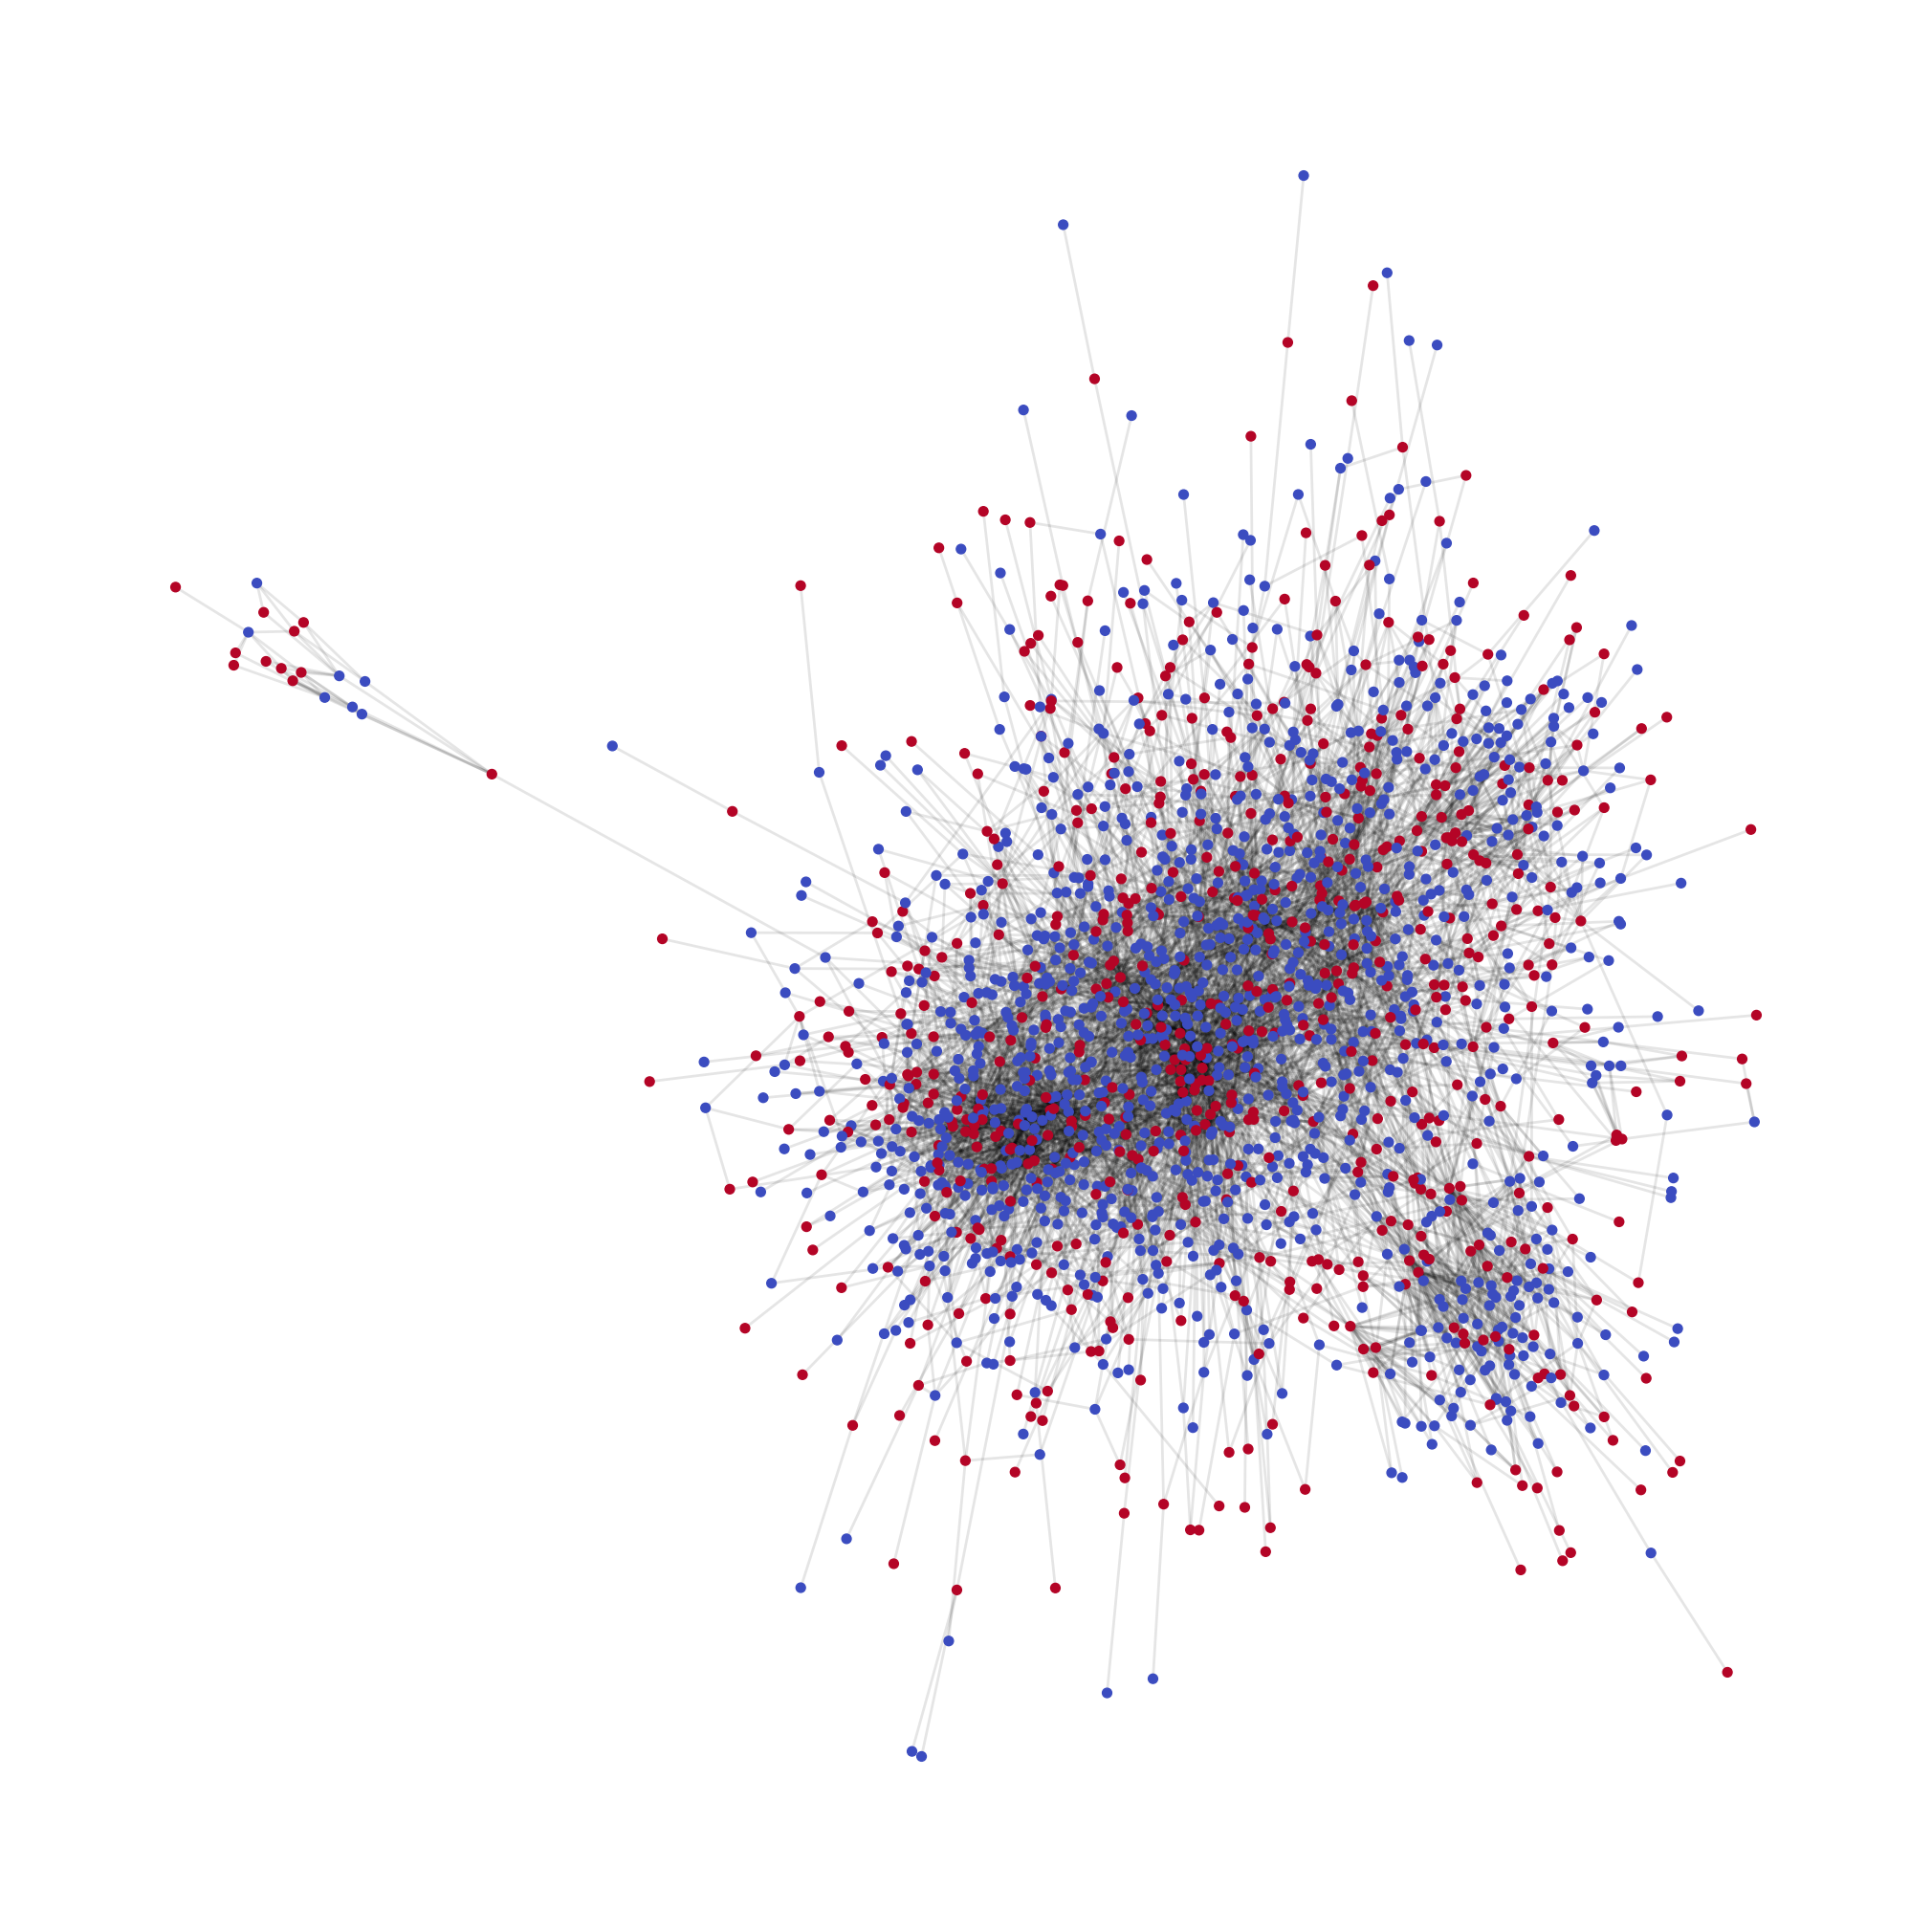

In [15]:
# Graph the large subgraph
color_map = {"playlist": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_lg.nodes(data=True)]
plt.figure(figsize=(20,20))
nx.draw(sub_G_lg,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 50,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

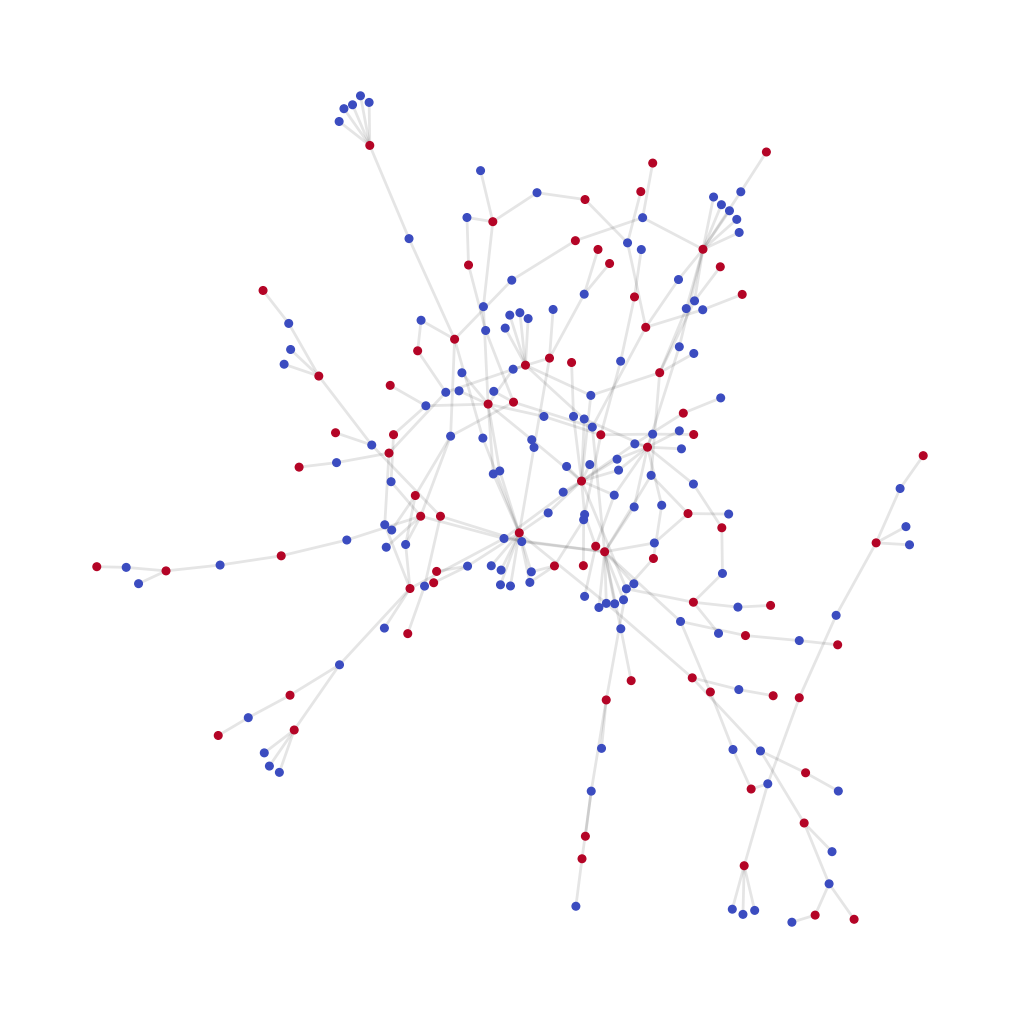

In [16]:
# Graph the subgraph of the small subgraph
color_map = {"playlist": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_sm.nodes(data=True)]
plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

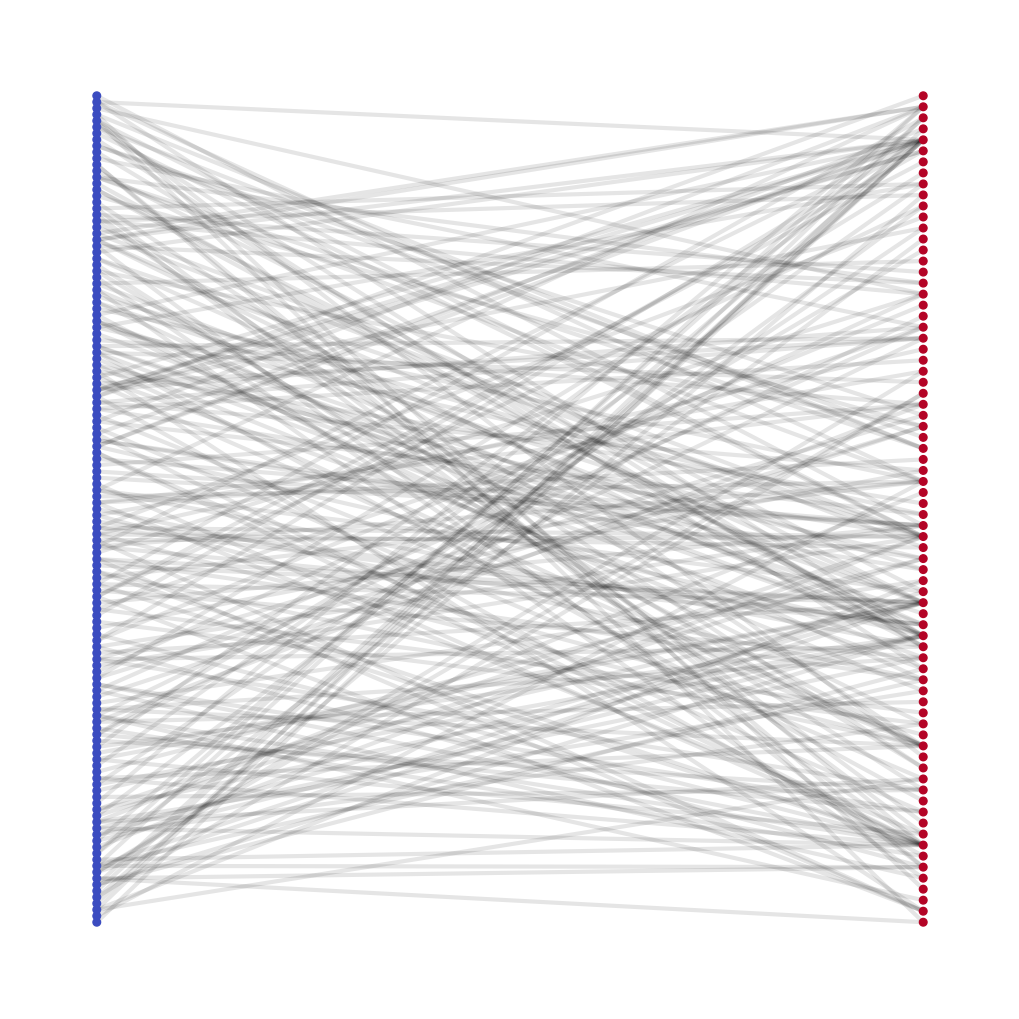

In [17]:
# Show the smaller subgraph as bipartite
top = nx.bipartite.sets(sub_G_sm)[0]
pos = nx.bipartite_layout(sub_G_sm, top)
plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        pos=pos,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 3,
        edge_color=(0, 0, 0, 0.1))

## Constructing a graph dataset

In order to use our graph with the graph. machine learning packages we installed, we need to do a bit of processing of the graph first.

In [18]:
# Note if you've already generated the graph above, you can skip those steps, and simply run set reload to True!
reload = False
if reload:
  G = pickle.load(open("30core_first_50.pkl", "rb"))
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 35300 . Num edges: 1606690


In [19]:
n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = sorted(list(G.nodes()))

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

G = nx.relabel_nodes(G, node2id)

# also keep track of how many playlists, tracks we have
playlists_idx = [i for i, v in enumerate(node2id.keys()) if "playlist" in v]
tracks_idx = [i for i, v in enumerate(node2id.keys()) if "track" in v]

n_playlists = np.max(playlists_idx) + 1
n_tracks = n_nodes - n_playlists

n_playlists, n_tracks

(22874, 12426)

When training a machine learning model, it's important to evaluate its performance on data that the model hasn't seen before to ensure its generalizability to unseen data. A train/validation/test split is used to achieve this by dividing the dataset into three sets: the training set, used to train the model; the validation set, used to tune the model's hyperparameters and prevent overfitting; and the test set, used to evaluate the model's performance on unseen data. We use a 70%-15%-15% split.

How does it work to split a graph? There is an extremely useful PyG method `RandomLinkSplit`, which will help us with that. This function works by randomly removing a specified percentage of the edges in the graph. The split is performed such that the training split doesn't include edges in the validation and test splits; and the validation split doesn't include edges in the test split. Also, since we plan to implement our own negative samplign algorithm we set add_negative_train_samples and neg_sampling_ratio to zero.

In [20]:
# turn the graph into a torch_geometric Data object

num_nodes = n_playlists +  n_tracks
edge_idx = torch.Tensor(np.array(G.edges()).T)
graph_data = Data(edge_index = edge_idx, num_nodes = num_nodes)

# convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.15, num_test=0.15
)
train_split, val_split, test_split = transform(graph_data)

From this split, we obtain two  types of edges: message-passing (`edge_index` and supervision edges (`edge_label_index`). Message passing edges are used to propagate information between nodes in the graph. Supervision edges, on the other hand, are used to supervise the training process, indicating the presence or absence of playlist-track link. These are the edges that we wish to predict.


In the next line, we need to assign them to the right type as they are initially stored as floats.

In [21]:
# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives upervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 572998 positives upervision edges
Validation set has 122784 positive supervision edges
Test set has 122784 positive supervision edges
Train set has 1145996 message passing edges
Validation set has 1145996 message passing edges
Test set has 1391564 message passing edges


We are now ready to get started implementing our model!

## Designing our model

To implement our model, we will be using the LightGCN architecture. This architecture forms a simple GNN method where we remove nonlinearity across layers. This leads to a highly scalable architecture with fewer parameters. By taking a weighted sum of the embeddings at different hop scales (also called multi-scale diffusion), LightGCN has exhibited better performance than other neural graph collaborative filtering approaches while also being computationally efficient.


To implement our models, we will customize the implementation of LightGCN from PyG.

One important note: the GNN method we are defining below acts as our full graph neural network, consisting of multiple message passing layers that are connected with skip connections (weighted according to the alpha parameter). We surface functionality to change the message passing layer from the default LightGCN layer to alternatives, such as a GAT and GraphSAGE convolution instead, as well as to have a learnable alpha parameter.

The three convolutional layers we use are the LGConv (from LightGCN), SAGEConv (GraphSAGE), and GATConv (GAT). We add a linear layer on top of the GATConv to take the concatenated outputs from the multiple attention heads back to the embedding dimension. Below we provide the update steps for each type of layer.

1. LGConv

\begin{equation*}
\mathbf{e}_i^{(k+1)} = \underset{j \in \mathcal{N}(i)}{\sum} \frac{1}{
  \sqrt{| \mathcal{N}(i)|} \sqrt{| \mathcal{N}(j)|} } \mathbf{e}_j^{(k)}
\end{equation*}


2. SAGEConv

\begin{equation*}
\mathbf{e}^{(k+1)}_{i} = \mathbf{W}_1 \mathbf{e}^{(k)}_{i} + \mathbf{W}_2 \frac{1}{| \mathcal{N}(i)|} \underset{j \in \mathcal{N}(i)}{\sum} \mathbf{e}^{(k)}_j
\end{equation*}

3. GATConv

\begin{align*}
    \mathbf{e}^{(k+1)}_i &= \mathbf{\Theta}\mathbf{x}_i^{(k+1)} + \mathbf{B} \\
    \mathbf{x}_i^{(k+1)} &= \underset{h=1}{\Big\Vert^H} \sum_{j \in \mathcal{N}(i) \cup \{i\} } \alpha_{ij}^h \mathbf{W}^h
    \mathbf{e}^{(k)}_j \\
    \alpha^h_{ij} &= \frac{
    \exp(
    \text{LeakyReLU}(\mathbf{a}^{h^{T}} \left[\mathbf{W}^h \mathbf{e}_i \Vert \mathbf{W}^h \mathbf{e}_j \right]))
    }{
    \underset{l \in \mathcal{N}(i) \cup \{i\}}{\sum}     \exp(
    \text{LeakyReLU}(\mathbf{a}^{h^{T}} \left[\mathbf{W}^h \mathbf{e}_i \Vert \mathbf{W}^h \mathbf{e}_l \right]))
    }
\end{align*}

No matter which convolutional layer we use, we still take the weighted sum of the different layers as is standard in LightGCN. We do so as follows:

\begin{equation*}
    \mathbf{e}_i = \sum_{k=1}^K \alpha_k \mathbf{e}^{(k)}_i
\end{equation*}


In [22]:
class GCN(torch.nn.Module):
    """
      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow
      for customizable convolutional layers, custom embeddings. In addition, we deifne some
      additional custom functions.

    """

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable = False,
        conv_layer = "LGC",
        name = None,
        **kwargs,
    ):
        super().__init__()
        alpha_string = "alpha" if alpha_learnable else ""
        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        if alpha_learnable == True:
          alpha_vals = torch.rand(num_layers+1)
          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))
          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")
        else:
          if alpha is None:
              alpha = 1. / (num_layers + 1)

          if isinstance(alpha, Tensor):
              assert alpha.size(0) == num_layers + 1
          else:
              alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers
        self.conv_layer = conv_layer
        if conv_layer == "LGC":
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          # initialize Graph Attention layer with multiple heads
          # initialize linear layers to aggregate heads
          n_heads = 5
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])

        elif conv_layer == "SAGE":
          #  initialize GraphSAGE conv
          self.convs = ModuleList(
              [SAGEConv(in_channels = embedding_dim, out_channels = embedding_dim, **kwargs) for _ in range(num_layers)]
          )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight

        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.conv_layer == "GAT":
              x = self.linears[i](x)
            out = out + x * weights[i + 1]

        return out

    def initialize_embeddings(self, data):
      # initialize with the data node features
        self.embedding.weight.data.copy_(data.node_feature)


    def forward(self, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            if isinstance(edge_index, SparseTensor):
                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)
            else:
                edge_label_index = edge_index

        out = self.get_embedding(edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,
                     prob: bool = False) -> Tensor:

        pred = self(edge_index, edge_label_index).sigmoid()
        return pred if prob else pred.round()

    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor:

        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        return (embed_src * embed_dst).sum(dim=-1)


    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:  # Map local top-indices to original indices.
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)

    def bpr_loss(self, pos_scores, neg_scores):
      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.embedding_dim}, num_layers={self.num_layers})')


Our main specifications will use a Bayesian Personalized Ranking, which is calculated as

\begin{equation*}
    \text{BPR Loss}(i) = \frac{1}{|\mathcal{E}(i)|} \underset{{(i, j_{+}) \in \mathcal{E}(i)}}{\sum} \log \sigma \left( \text{score}(i, j_+) - \text{score}(i, j_-) \right)
\end{equation*}

for a pair of positive edge $(i, j_{+})$ and negative edge $(i, j_{-})$. More on how we define a negative edge later.

In [23]:
class BPRLoss(_Loss):
    r"""The Bayesian Personalized Ranking (BPR) loss.

    The BPR loss is a pairwise loss that encourages the prediction of an
    observed entry to be higher than its unobserved counterparts
    (see `here <https://arxiv.org/abs/2002.02126>`__).

    .. math::
        L_{\text{BPR}} = - \sum_{u=1}^{M} \sum_{i \in \mathcal{N}_u}
        \sum_{j \not\in \mathcal{N}_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj})
        + \lambda \vert\vert \textbf{x}^{(0)} \vert\vert^2

    where :math:`lambda` controls the :math:`L_2` regularization strength.
    We compute the mean BPR loss for simplicity.

    Args:
        lambda_reg (float, optional): The :math:`L_2` regularization strength
            (default: 0).
        **kwargs (optional): Additional arguments of the underlying
            :class:`torch.nn.modules.loss._Loss` class.
    """
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.

        .. note::

            The i-th entry in the :obj:`positives` vector and i-th entry
            in the :obj:`negatives` entry should correspond to the same
            entity (*.e.g*, user), as the BPR is a personalized ranking loss.

        Args:
            positives (Tensor): The vector of positive-pair rankings.
            negatives (Tensor): The vector of negative-pair rankings.
            parameters (Tensor, optional): The tensor of parameters which
                should be used for :math:`L_2` regularization
                (default: :obj:`None`).
        """
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

## Defining training, test functions

### Negative sampling

Important to any link prediction task is negative sampling. In the graph, we observe positive edges, which allows us to capture which nodes should be most similar to one another. Adding negative edges allows the model to explicitly capture that nodes that don't share an edge should have different embeddings. Without negative edges, you can convince yourself that a valid loss minimization strategy would be to simply assign all nodes the same embedding, which is obviously not meaningful or desirable.

Consequently, in this section, we define our negative sampling strategy. In particular, we take three approaches:
1. Random, no positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. For computational efficiency, we don't check if ($p_i$, $t_j$) is actually a negative edge, though probabilistically it is very likely.
2. Random, positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. We ensure that ($p_i$, $t_j$) is not a positive edge.
3. Hard: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the top $k$ proportion of tracks, ranked by dot product similarity to $p_i$. For epoch 0, $k = 1$ and we lower it at each subsequent iteration.

In [24]:
def sample_negative_edges_nocheck(data, num_playlists, num_tracks, device = None):
  # note computationally inefficient to check that these are indeed negative edges
  playlists = data.edge_label_index[0, :]
  tracks = torch.randint(num_playlists, num_playlists + num_tracks - 1, size = data.edge_label_index[1, :].size())

  if playlists.get_device() != -1: # on gpu
    tracks = tracks.to(device)

  neg_edge_index = torch.stack((playlists, tracks), dim = 0)
  neg_edge_label = torch.zeros(neg_edge_index.shape[1])

  if neg_edge_index.get_device() != -1: # on gpu
    neg_edge_label = neg_edge_label.to(device)

  return neg_edge_index, neg_edge_label

def sample_negative_edges(data, num_playlists, num_tracks, device=None):
    positive_playlists, positive_tracks = data.edge_label_index

    # Create a mask tensor with the shape (num_playlists, num_tracks)
    mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    mask[positive_playlists, positive_tracks - num_playlists] = True

    # Flatten the mask tensor and get the indices of the negative edges
    flat_mask = mask.flatten()
    negative_indices = torch.where(~flat_mask)[0]

    # Sample negative edges from the negative_indices tensor
    sampled_negative_indices = negative_indices[
        torch.randint(0, negative_indices.size(0), size=(positive_playlists.size(0),), device=device)
    ]

    # Convert the indices back to playlists and tracks tensors
    playlists = torch.floor_divide(sampled_negative_indices, num_tracks)
    tracks = torch.remainder(sampled_negative_indices, num_tracks)
    tracks = tracks + num_playlists

    neg_edge_index = torch.stack((playlists, tracks), dim=0)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=device)

    return neg_edge_index, neg_edge_label

def sample_hard_negative_edges(data, model, num_playlists, num_tracks, device=None, batch_size=500, frac_sample = 1):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:num_playlists].to(device)
        tracks_embeddings = embeddings[num_playlists:].to(device)

    positive_playlists, positive_tracks = data.edge_label_index
    num_edges = positive_playlists.size(0)

    # Create a boolean mask for all the positive edges
    positive_mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    positive_mask[positive_playlists, positive_tracks - num_playlists] = True

    neg_edges_list = []
    neg_edge_label_list = []

    for batch_start in range(0, num_edges, batch_size):
        batch_end = min(batch_start + batch_size, num_edges)

        batch_scores = torch.matmul(
            playlists_embeddings[positive_playlists[batch_start:batch_end]], tracks_embeddings.t()
        )

        # Set the scores of the positive edges to negative infinity
        batch_scores[positive_mask[positive_playlists[batch_start:batch_end]]] = -float("inf")

        # Select the top k highest scoring negative edges for each playlist in the current batch
        # do 0.99 to filter out all pos edges which will be at the end
        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_tracks), dim=1)
        selected_indices = torch.randint(0, int(frac_sample * 0.99 *num_tracks), size = (batch_end - batch_start, ))
        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + n_playlists

        # Create the negative edges tensor for the current batch
        neg_edges_batch = torch.stack(
            (positive_playlists[batch_start:batch_end], top_indices_selected), dim=0
        )
        neg_edge_label_batch = torch.zeros(neg_edges_batch.shape[1], device=device)

        neg_edges_list.append(neg_edges_batch)
        neg_edge_label_list.append(neg_edge_label_batch)

    # Concatenate the batch tensors
    neg_edges = torch.cat(neg_edges_list, dim=1)
    neg_edge_label = torch.cat(neg_edge_label_list)

    return neg_edges, neg_edge_label

### Evaluation

In addition, to calculating the loss, we would like to have other metrics to evaluate the quality of our predictions.

First, we consider one common metric for recommender systems: Recall@K. This is defined as follows: for a playlist $i$, $P^k_i$ represents the set of the top $k$ predicted tracks for $i$ and $R_i$ the ground truth of connected tracks to playlist $i$, then we calculate
$$
\text{recall}^k_i = \frac{| P^k_i \cap R_i | }{|R_i|}.
$$
If $R_i = 0$, then we assign this value to 1. Note, if $R_i \subset P_i^k$, then the recall is equal to 1. Hence, our choice of $k$ matters a lot.

Note: when evaluating this metric on our validation or test set, we need to make sure to filter the message passing edges from consideration, as the model can directly observe these.

We choose a value of $k = 300$, which seems reasonable given the overall number of possible tracks is 12,247.

In [25]:
def recall_at_k(data, model, k = 300, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

In addition, we calculate the ROC AUC score for the binary predictions, which provides a measure of the efficiency of our model at distinguishing `true' track-playlist edges from non-existing ones. The higher this score, the better (a perfect score is achieved when ROC AUC = 1).

In [26]:
def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  return roc

### Main train / test functions

Now we define our main train and test functions, which will handle model training and evaluation.

In [27]:
# Train
def train(datasets, model, optimizer, loss_fn, args, neg_samp = "random"):
  print(f"Beginning training for {model.name}")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): # loop over each epoch
    model.train()
    optimizer.zero_grad()

    # obtain negative sample
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(train_data, n_playlists, n_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0:
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            train_data, model, n_playlists, n_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    # calculate loss function
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_neg_edge, val_neg_label = test(
        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label
    )

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 10 == 0:
      # calculate recall @ K
      val_recall = recall_at_k(val_data, model, k = 300, device = args["device"])
      print(f"Val recall {val_recall}")
      stats['val']['recall'].append(val_recall)

    if epoch % 20 == 0:

      # save embeddings for future visualization
      path = os.path.join("model_embeddings", model.name)
      if not os.path.exists(path):
        os.makedirs(path)
      torch.save(model.embedding.weight, os.path.join("model_embeddings", model.name, f"{model.name}_{loss_fn}_{neg_samp}_{epoch}.pt"))

  pickle.dump(stats, open(f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pkl", "wb"))
  return stats

def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):

  model.eval()
  with torch.no_grad(): # want to save RAM

    # conduct negative sampling
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(data, n_playlists, n_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0 or neg_edge_index is None:
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            data, model, n_playlists, n_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # obtain model embedding
    embed = model.get_embedding(data.edge_index)
    # calculate pos, neg scores using embedding
    pos_scores = model.predict_link_embedding(embed, data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)
    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    # calculate loss
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = metrics(labels, scores)

  return loss, roc, neg_edge_index, neg_edge_label

## Training models

### Set up hyperparameters and arguments

Run through these cells to set up all the hyperparameters and arguments we will need to run our models.

In [28]:
# create a dictionary of the dataset splits
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [29]:
# initialize our arguments
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301
}

In [30]:
# initialize model and and optimizer
num_nodes = n_playlists + n_tracks
model = GCN(
    num_nodes = num_nodes, num_layers = args['num_layers'],
    embedding_dim = args["emb_size"], conv_layer = "SAGE"
)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [31]:
# send data, model to GPU if available
playlists_idx = torch.Tensor(playlists_idx).type(torch.int64).to(args["device"])
tracks_idx =torch.Tensor(tracks_idx).type(torch.int64).to(args["device"])
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])
model.to(args["device"])

GCN(35300, 64, num_layers=3)

In [32]:
# create directory to save model_stats
MODEL_STATS_DIR = "model_stats"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

In [33]:
train(datasets, model, optimizer, "BPR", args, neg_samp = "random")

Beginning training for LGCN_SAGE_3_e64_nodes35300_
Epoch 0; Train loss 0.6928228735923767; Val loss 0.6775438785552979; Train ROC 0.5193393005113754; Val ROC 0.8073894731629803
Val recall 0.1972469836473465
Epoch 1; Train loss 0.676948606967926; Val loss 0.5889372825622559; Train ROC 0.8170985572447904; Val ROC 0.7885148503960464
Epoch 2; Train loss 0.5851565003395081; Val loss 0.4966893196105957; Train ROC 0.7944031108910653; Val ROC 0.7728080211435289
Epoch 3; Train loss 0.4810738265514374; Val loss 0.4098159670829773; Train ROC 0.7794378728454898; Val ROC 0.8151660031633979
Epoch 4; Train loss 0.39084261655807495; Val loss 0.38484013080596924; Train ROC 0.8235545373001023; Val ROC 0.8293738332499176
Epoch 5; Train loss 0.35998159646987915; Val loss 0.40594109892845154; Train ROC 0.8401787889294687; Val ROC 0.825230476677614
Epoch 6; Train loss 0.3777260184288025; Val loss 0.3993510901927948; Train ROC 0.8368476669666867; Val ROC 0.8246163630952734
Epoch 7; Train loss 0.3751548230648

{'train': {'loss': [tensor(0.6928, grad_fn=<DivBackward0>),
   tensor(0.6769, grad_fn=<DivBackward0>),
   tensor(0.5852, grad_fn=<DivBackward0>),
   tensor(0.4811, grad_fn=<DivBackward0>),
   tensor(0.3908, grad_fn=<DivBackward0>),
   tensor(0.3600, grad_fn=<DivBackward0>),
   tensor(0.3777, grad_fn=<DivBackward0>),
   tensor(0.3752, grad_fn=<DivBackward0>),
   tensor(0.3652, grad_fn=<DivBackward0>),
   tensor(0.3548, grad_fn=<DivBackward0>),
   tensor(0.3494, grad_fn=<DivBackward0>),
   tensor(0.3535, grad_fn=<DivBackward0>),
   tensor(0.3452, grad_fn=<DivBackward0>),
   tensor(0.3376, grad_fn=<DivBackward0>),
   tensor(0.3415, grad_fn=<DivBackward0>),
   tensor(0.3400, grad_fn=<DivBackward0>),
   tensor(0.3368, grad_fn=<DivBackward0>),
   tensor(0.3364, grad_fn=<DivBackward0>),
   tensor(0.3316, grad_fn=<DivBackward0>),
   tensor(0.3312, grad_fn=<DivBackward0>),
   tensor(0.3321, grad_fn=<DivBackward0>),
   tensor(0.3286, grad_fn=<DivBackward0>),
   tensor(0.3280, grad_fn=<DivBackwar

In [34]:
test(model, datasets['test'], "BPR", neg_samp = "random")

(tensor(0.1611),
 0.9385000500363804,
 tensor([[16141,  2647,  1625,  ...,  9191,  6795, 20100],
         [24439, 26605, 27518,  ..., 28862, 31455, 25399]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

### Comparison of approaches

We define a helper function `init_model` to make training different specifications more straightforward. Simply pass in your args, the convolutional layer you want and train away!

In [35]:
def init_model(conv_layer, args, alpha = False):
  num_nodes = n_playlists + n_tracks
  model = GCN(
      num_nodes = num_nodes, num_layers = args['num_layers'],
      embedding_dim = args["emb_size"], conv_layer = conv_layer,
      alpha_learnable = alpha
  )
  model.to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  return model, optimizer

In [36]:
## For example:

# using BPR loss
loss_fn = "BPR"

# using hard sampling
neg_samp = "hard"

# for LGConv:
args['epochs'] = 301
args['num_layers'] = 4
model, optimizer = init_model("LGC", args)
lgc_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes35300_
Epoch 0; Train loss 0.6931434273719788; Val loss 0.6931455135345459; Train ROC 0.6031343617302903; Val ROC 0.6648355177808769
Val recall 0.23817919194698334
Epoch 1; Train loss 0.6931448578834534; Val loss 0.6931272149085999; Train ROC 0.7484064430238383; Val ROC 0.7696938626312327
Epoch 2; Train loss 0.6931255459785461; Val loss 0.6929804682731628; Train ROC 0.8115332516864693; Val ROC 0.8091388601553676
Epoch 3; Train loss 0.692972719669342; Val loss 0.6923887133598328; Train ROC 0.8279763475034998; Val ROC 0.8087243132240012
Epoch 4; Train loss 0.6923589110374451; Val loss 0.6908544301986694; Train ROC 0.8190368081911383; Val ROC 0.8071328063792421
Epoch 5; Train loss 0.6908031105995178; Val loss 0.6878834962844849; Train ROC 0.812769381917748; Val ROC 0.8055022129404161
Epoch 6; Train loss 0.6876983046531677; Val loss 0.68290114402771; Train ROC 0.8133198979238897; Val ROC 0.8067065140877417
Epoch 7; Train loss 0.682531476020813; Va

In [37]:
# for GATConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("GAT", args)
gat_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_GAT_3_e64_nodes35300_
Epoch 0; Train loss 0.6931461095809937; Val loss 0.6925792694091797; Train ROC 0.5029926215993004; Val ROC 0.7687956341056734
Val recall 0.24017499387264252
Epoch 1; Train loss 0.6925504207611084; Val loss 0.6867865324020386; Train ROC 0.7601352703446819; Val ROC 0.7615843986466246
Epoch 2; Train loss 0.6864490509033203; Val loss 0.5410763621330261; Train ROC 0.7118959973739097; Val ROC 0.682545094044102
Epoch 3; Train loss 0.6230388283729553; Val loss 0.6468597650527954; Train ROC 0.6211317397746257; Val ROC 0.7182493322345674
Epoch 4; Train loss 0.6450544595718384; Val loss 0.6201950907707214; Train ROC 0.7182187669442568; Val ROC 0.7188918002234678
Epoch 5; Train loss 0.6199303865432739; Val loss 0.4739464521408081; Train ROC 0.7183400627649414; Val ROC 0.7157436583245829
Epoch 6; Train loss 0.4629402756690979; Val loss 1.863526463508606; Train ROC 0.7196218662620083; Val ROC 0.7221669461252079
Epoch 7; Train loss 1.7489641904830933;

In [38]:
# for SAGEConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("SAGE", args)
sage_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_SAGE_3_e64_nodes35300_
Epoch 0; Train loss 0.693042516708374; Val loss 0.6817395091056824; Train ROC 0.5086374194784222; Val ROC 0.7521372820677453
Val recall 0.22486165165901184
Epoch 1; Train loss 0.6808657050132751; Val loss 0.602555513381958; Train ROC 0.7600188816986523; Val ROC 0.7372453471708873
Epoch 2; Train loss 0.5980766415596008; Val loss 0.4723505675792694; Train ROC 0.7436729658649192; Val ROC 0.7273324284152617
Epoch 3; Train loss 0.45658743381500244; Val loss 0.6022946834564209; Train ROC 0.7334922130354563; Val ROC 0.7394348756015869
Epoch 4; Train loss 0.5615814328193665; Val loss 0.4513247013092041; Train ROC 0.7464374649473056; Val ROC 0.7492806975812314
Epoch 5; Train loss 0.4372967779636383; Val loss 0.4843983054161072; Train ROC 0.7523355649153911; Val ROC 0.7508589595212842
Epoch 6; Train loss 0.47231942415237427; Val loss 0.5087124109268188; Train ROC 0.7579942253722107; Val ROC 0.7486296952820043
Epoch 7; Train loss 0.49677103757858

In [39]:
# using random sampling
neg_samp = "random"

# for LGConv:
args['epochs'] = 301
args['num_layers'] = 4
model, optimizer = init_model("LGC", args)
lgc_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes35300_
Epoch 0; Train loss 0.6931431889533997; Val loss 0.6931450963020325; Train ROC 0.6080192711479562; Val ROC 0.6981384426559446
Val recall 0.2525809407234192
Epoch 1; Train loss 0.6931445002555847; Val loss 0.6931189298629761; Train ROC 0.7780435686833854; Val ROC 0.808230963059642
Epoch 2; Train loss 0.6931167840957642; Val loss 0.6928946375846863; Train ROC 0.8479823302986003; Val ROC 0.8342550022007772
Epoch 3; Train loss 0.6928836107254028; Val loss 0.6919944286346436; Train ROC 0.8502359500969963; Val ROC 0.8401131578051187
Epoch 4; Train loss 0.6919514536857605; Val loss 0.6897335052490234; Train ROC 0.8502514319337647; Val ROC 0.8450426874498453
Epoch 5; Train loss 0.6896053552627563; Val loss 0.6853803396224976; Train ROC 0.855155140545494; Val ROC 0.8508159325615998
Epoch 6; Train loss 0.6851078271865845; Val loss 0.6783836483955383; Train ROC 0.8602931003363845; Val ROC 0.854617264256093
Epoch 7; Train loss 0.6778739094734192; V

In [40]:
# for GATConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("GAT", args)
gat_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_GAT_3_e64_nodes35300_
Epoch 0; Train loss 0.6931464076042175; Val loss 0.6923059225082397; Train ROC 0.5026963360455258; Val ROC 0.8212197668850392
Val recall 0.2387816607952118
Epoch 1; Train loss 0.6922772526741028; Val loss 0.6827434301376343; Train ROC 0.8120483351228064; Val ROC 0.8112731496012389
Epoch 2; Train loss 0.6823964715003967; Val loss 0.6633564233779907; Train ROC 0.7369941377204442; Val ROC 0.6946499402894843
Epoch 3; Train loss 0.9931074976921082; Val loss 0.6705427169799805; Train ROC 0.6241311546896862; Val ROC 0.7919443161298078
Epoch 4; Train loss 0.6700022220611572; Val loss 0.68644118309021; Train ROC 0.7554412569049311; Val ROC 0.795112423986761
Epoch 5; Train loss 0.6862215995788574; Val loss 0.6881281137466431; Train ROC 0.7985701369512276; Val ROC 0.781155061821295
Epoch 6; Train loss 0.687900722026825; Val loss 0.6858606338500977; Train ROC 0.7894053682874389; Val ROC 0.7585506548454303
Epoch 7; Train loss 0.6855608224868774; Val

In [41]:
# for SAGEConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("SAGE", args)
sage_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_SAGE_3_e64_nodes35300_
Epoch 0; Train loss 0.6927790641784668; Val loss 0.6758249998092651; Train ROC 0.5211475161896224; Val ROC 0.808566893811393
Val recall 0.20833609998226166
Epoch 1; Train loss 0.6750239729881287; Val loss 0.581199586391449; Train ROC 0.8179035881745216; Val ROC 0.7842241713468006
Epoch 2; Train loss 0.5771130323410034; Val loss 0.5154935717582703; Train ROC 0.7907192964753786; Val ROC 0.7686110022407392
Epoch 3; Train loss 0.49903833866119385; Val loss 0.4166823923587799; Train ROC 0.7754313188310537; Val ROC 0.8116192115817751
Epoch 4; Train loss 0.399018257856369; Val loss 0.3876779079437256; Train ROC 0.8196118237591612; Val ROC 0.8266451150690608
Epoch 5; Train loss 0.36578667163848877; Val loss 0.4031670391559601; Train ROC 0.8376611581463221; Val ROC 0.8265402871726862
Epoch 6; Train loss 0.37500306963920593; Val loss 0.4070504307746887; Train ROC 0.8383895560200556; Val ROC 0.8265252333556945
Epoch 7; Train loss 0.38117304444313

## Training visualizations

Define some helper functions for our visualizations.

In [42]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  plt.show()

In [ ]:
# If you had to stop for whatever reason, you can always reload the stats here! (just uncomment and change to correct paths)
#lgc_stats = pickle.load(open(f"/Users/hayoon/Desktop/gnn-recommender/model_stats/LGCN_LGC_4_e64_nodes34810__BPR_random.pkl", "rb"))
#gat_stats = pickle.load(open(f"/Users/hayoon/Desktop/gnn-recommender/model_stats/LGCN_GAT_3_e64_nodes34810__BPR_random.pkl", "rb"))
#sage_stats = pickle.load(open(f"/Users/hayoon/Desktop/gnn-recommender/model_stats/LGCN_SAGE_3_e64_nodes34810__BPR_random.pkl", "rb"))
#lgc_stats_hard = pickle.load(open(f"/Users/hayoon/Desktop/gnn-recommender/model_stats/LGCN_LGC_4_e64_nodes34810__BPR_hard.pkl", "rb"))
#gat_stats_hard = pickle.load(open(f"/Users/hayoon/Desktop/gnn-recommender/model_stats/LGCN_GAT_3_e64_nodes34810__BPR_hard.pkl", "rb"))
#sage_stats_hard = pickle.load(open(f"/Users/hayoon/Desktop/gnn-recommender/model_stats/LGCN_SAGE_3_e64_nodes34810__BPR_hard.pkl", "rb"))

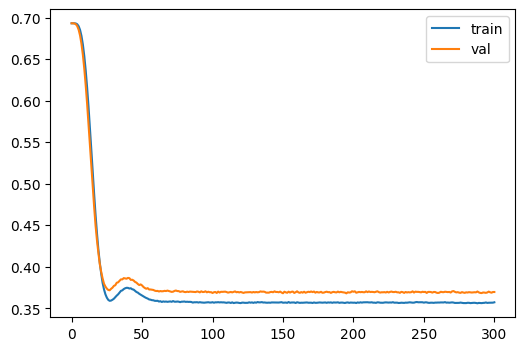

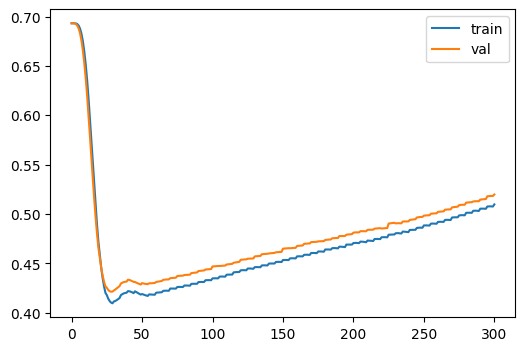

In [46]:
plot_train_val_loss(lgc_stats)
plot_train_val_loss(lgc_stats_hard)

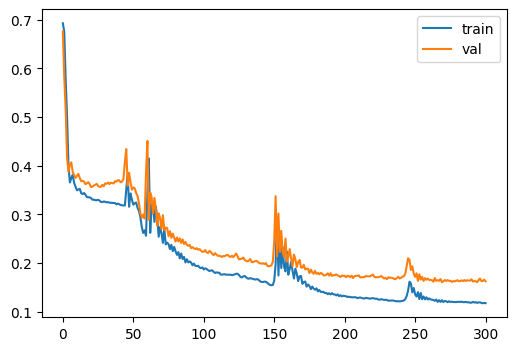

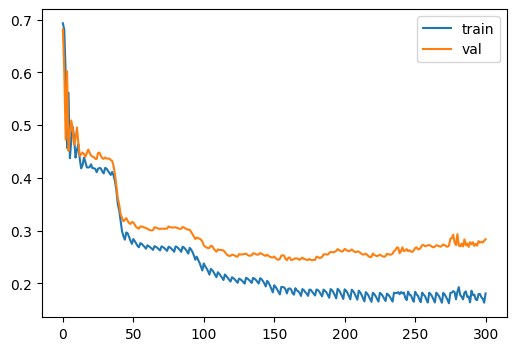

In [47]:
plot_train_val_loss(sage_stats)
plot_train_val_loss(sage_stats_hard)

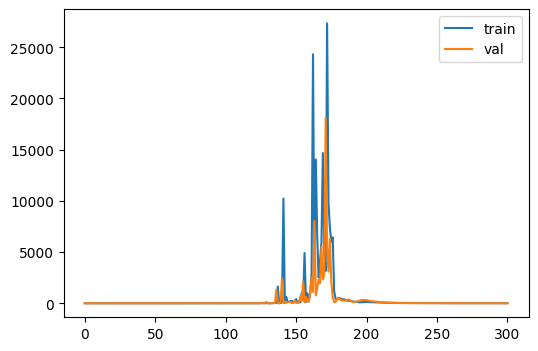

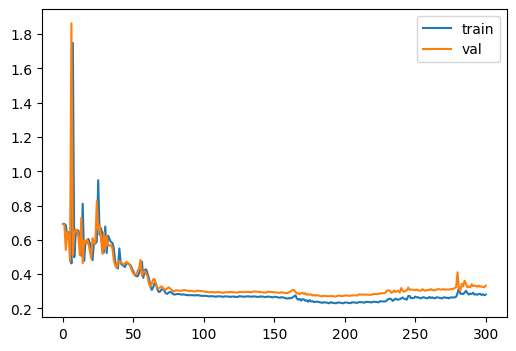

In [48]:
plot_train_val_loss(gat_stats)
plot_train_val_loss(gat_stats_hard)

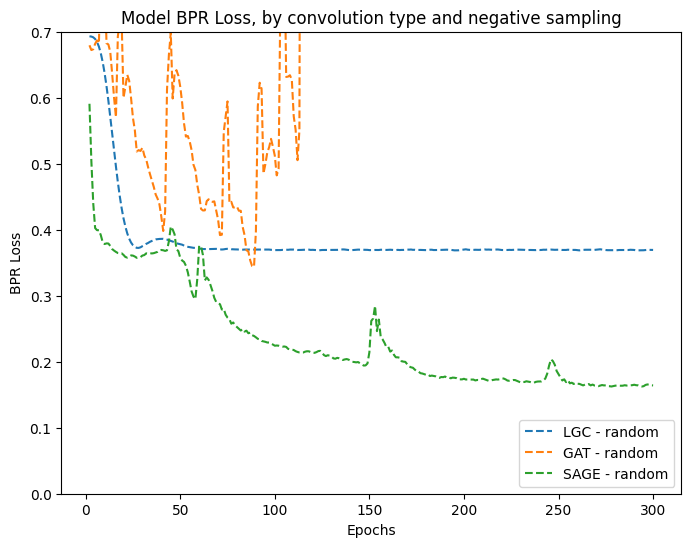

In [49]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats["val"][key])).rolling(3).mean()
gat_loss = pd.Series(detach_loss(gat_stats["val"][key])).rolling(3).mean()
sage_loss = pd.Series(detach_loss(sage_stats["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, gat_loss, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, sage_loss, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()

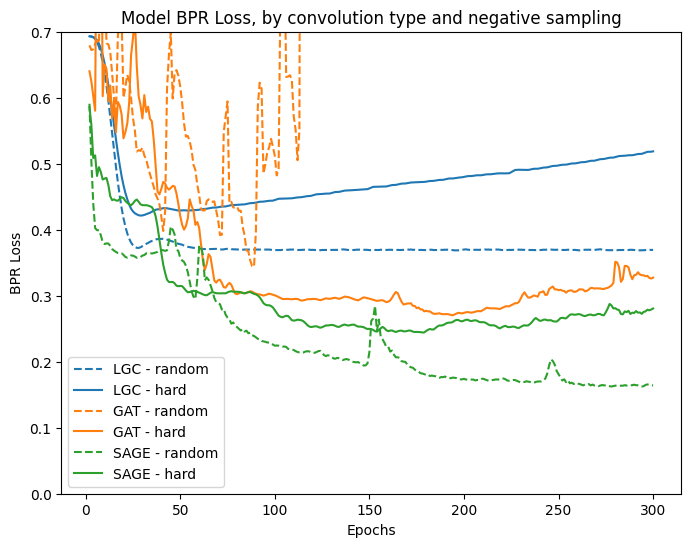

In [50]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats["val"][key])).rolling(3).mean()
gat_loss = pd.Series(detach_loss(gat_stats["val"][key])).rolling(3).mean()
sage_loss = pd.Series(detach_loss(sage_stats["val"][key])).rolling(3).mean()
lgc_hard_loss = pd.Series(detach_loss(lgc_stats_hard["val"][key])).rolling(3).mean()
gat_hard_loss = pd.Series(detach_loss(gat_stats_hard["val"][key])).rolling(3).mean()
sage_hard_loss = pd.Series(detach_loss(sage_stats_hard["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_loss, color = colors[0], label = "LGC - hard")
ax.plot(idx, gat_loss, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, gat_hard_loss, color = colors[1], label = "GAT - hard")
ax.plot(idx, sage_loss, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx, sage_hard_loss, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower left')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()


Now that we've produced models, let's visualize the embeddings of some of our models. Since our embeddings are in 64 dimensions, we use [uniform manifold approximation and projection](https://umap-learn.readthedocs.io/en/latest/) to reduce the embeddings to three dimensions so that we can visualize them. We chose to explore the 30-core SAGEConv model that was trained on 50 data files.

In [71]:
# Imports specifc to visualizations
import matplotlib.animation as animation
import umap
from IPython import display
from math import floor, ceil

In [72]:
# Reduce 64-dim embeddings to 3-dim using umap
umap_embs = [] # dimensionally reduced embeddings
umap_embs_negsamp = [] # indicates if index is a hard negative sampling embedding
rand, hard = 0, 1 # enumeration of types of negative sampling
negsamp = ["Random", "Hard"] # used in plot titles
epoch_str = [] # what epoch produced the embeddings

# Directory contianing the selected model embeddings
model_dir = "/Users/hayoon/Desktop/gnn-recommender/model_embeddings/LGCN_SAGE_3_e64_nodes35300_"

for filename in tqdm(sorted(os.listdir(join(os.getcwd(), model_dir)),
                       key=lambda name: int(name[:-3].split('_')[-1]))):
  embs = torch.load(join(os.getcwd(), model_dir, filename), map_location=torch.device('cpu')).detach().cpu().numpy()
  embs = embs[:n_playlists]
  u = umap.UMAP(init='random', random_state=224, n_components=3).fit_transform(embs)
  if 'hard' in filename:
    umap_embs_negsamp.append(1)
  else:
    umap_embs_negsamp.append(0)
  umap_embs.append(u)
  epoch_str.append(filename[:-3].split('_')[-1])

  0%|          | 0/32 [00:00<?, ?it/s]

/Users/hayoon/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/hayoon/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/hayoon/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/hayoon/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for p

In [56]:
# Separate the embeddings dimensions for plotting
n = len(umap_embs)
n_emb = len(umap_embs[0])

def extract_dim(dim):
  """Given a dim index, return just that dim of umap_embs"""
  return [[umap_embs[i][j][dim] for j in range(n_emb)] for i in range(n)]

x = extract_dim(0)
y = extract_dim(1)
z = extract_dim(2)

def compute_min_max(dim, h):
  """Given a dim index and negative sampling type, compute dim limits"""
  dim = [dim[i] for i in range(n) if umap_embs_negsamp[i] == h]
  return floor(min([min(dim[i]) for i in range(len(dim))])), ceil(max([max(dim[i]) for i in range(len(dim))]))

In [57]:
def plot_embeddings(h, select_idx=None, color=None):
  """
  Given a negative sampling type, plot the playlist embeddings.
  Optional parameters: select_idx, color are the selected
  indices to plot and the associated color mappings
  """
  # Indecies of embeddings of type t (rand, hard)
  idx = [i for i in range(n) if umap_embs_negsamp[i] == h]

  # Set up plot
  fig = plt.figure(figsize = (10, 10))
  subplt = plt.axes(projection ="3d")
  # Initialize the scatter plot
  if (select_idx):
    my_cmap = plt.get_cmap('cividis')
    sct = subplt.scatter([x[idx[0]][i] for i in select_idx],
                          [y[idx[0]][i] for i in select_idx],
                          [z[idx[0]][i] for i in select_idx],
                          alpha = 0.8,
                          c = color,
                          cmap = my_cmap,
                          marker ='o')
  else:
    sct = subplt.scatter(x[idx[0]], y[idx[0]], z[idx[0]],
                          alpha = 0.8, marker ='o')
  # Set axis limit
  subplt.set_xlim(compute_min_max(x, h))
  subplt.set_xlabel('x')
  subplt.set_ylim(compute_min_max(y, h))
  subplt.set_xlabel('y')
  subplt.set_zlim(compute_min_max(z, h))
  subplt.set_xlabel('z')

  # Define animation update funcion
  def update(itr, xa, ya, za, t):
    i = idx[itr]
    subplt.set_title('Embedding Epoch: ' + epoch_str[i] +
                     ", " + negsamp[t] +
                     " Negative Sampling")
    if (select_idx):
      xyz = ([xa[i][j] for j in select_idx],
             [ya[i][j] for j in select_idx],
             [za[i][j] for j in select_idx])
    else:
      xyz = (xa[i], ya[i], za[i])
    sct._offsets3d = xyz
    return sct

  # Create animation
  ani = animation.FuncAnimation(fig, update,
                                fargs=(x, y, z, h),
                                interval=500,
                                save_count=len(idx))
  video = ani.to_html5_video()
  html = display.HTML(video)
  display.display(html)
  plt.close()

Now let's watch the animated video as the playlist embeddings change between epochs! We collected embeddings every few epochs, so the transition between embeddings is not smooth. We first graph the embeddings for the version of the selected model that uses random negative sampling and then for the version that uses hard negative sampling.

In [59]:
plot_embeddings(rand)

In [60]:
plot_embeddings(hard)

Now that we've explored the general distribution of all playlist embeddings, we can investigate the embeddings of playlist that feature particular artists. Specifically, we investigate playlists that featured Glass Animals (artist id: 4yvcSjfu4PC0CYQyLy4wSq) and Gryffin (artist id: 2ZRQcIgzPCVaT9XKhXZIzh). We find all playlists that feature Glass Animals but not Gryffin (yellow), playlists that feature both (gray), and playlists that feature Gryffin but not Glass Animals (blue).

In [68]:
def artist_idxs_and_colors(a1_num, a2_num):
  '''
  Given two spotify artist identifiers (a1_num, a2_num),
  collect the indices of all playlists featuring the artists.
  Return the indices in the order of playlists featuring only
  artist 1 (blue), playlists featuring both(gray), and then
  playlists featuring only artist 2 (yellow). Return a color
  map indicating which index is in which category.
  '''
  a1 = 'spotify:artist:' + a1_num
  a2 = 'spotify:artist:' + a2_num

  # Collect indices of playlists featuring the artists
  # Feature both
  both_idx = [i for i in playlists_idx if i.item() in id2node and 
            a1 in playlist_data[id2node[i.item()]].artists and 
            a2 in playlist_data[id2node[i.item()]].artists]

  a1_only_idx = [i for i in playlists_idx if i.item() in id2node and 
               a1 in playlist_data[id2node[i.item()]].artists and 
               i.item() not in both_idx]

  a2_only_idx = [i for i in playlists_idx if i.item() in id2node and 
               a2 in playlist_data[id2node[i.item()]].artists and 
               i.item() not in both_idx]

  # Combine into single ordered list
  all_idx = a1_only_idx + both_idx + a2_only_idx
  # Compute color mappings
  color = [0 for i in range(len(a1_only_idx))] + \
          [0.5 for i in range(len(both_idx))] + \
          [1 for i in range(len(a2_only_idx))]

  return all_idx, color

In [69]:
def plot_two_artists_embeddings(a1, a2, h):
  """
  Given two spotify artist ids, plot the playlists
  featuring those artists.
  """
  # Indices of playlist with selected artists
  select_idx, color = artist_idxs_and_colors(a1, a2)

  plot_embeddings(h, select_idx, color)

In [70]:
a1 = '2ZRQcIgzPCVaT9XKhXZIzh' # gryffin
a2 = '4yvcSjfu4PC0CYQyLy4wSq' # glass animals
plot_two_artists_embeddings(a1, a2, rand)

In [64]:
id2node

{0: 'playlist_0',
 1: 'playlist_10',
 2: 'playlist_10005',
 3: 'playlist_10009',
 4: 'playlist_10010',
 5: 'playlist_10013',
 6: 'playlist_10014',
 7: 'playlist_10015',
 8: 'playlist_10018',
 9: 'playlist_10019',
 10: 'playlist_10020',
 11: 'playlist_10021',
 12: 'playlist_10025',
 13: 'playlist_1003',
 14: 'playlist_10030',
 15: 'playlist_10031',
 16: 'playlist_10032',
 17: 'playlist_10034',
 18: 'playlist_10037',
 19: 'playlist_10038',
 20: 'playlist_10039',
 21: 'playlist_1004',
 22: 'playlist_10040',
 23: 'playlist_10044',
 24: 'playlist_10051',
 25: 'playlist_10052',
 26: 'playlist_10057',
 27: 'playlist_10058',
 28: 'playlist_1006',
 29: 'playlist_10061',
 30: 'playlist_10062',
 31: 'playlist_10063',
 32: 'playlist_10068',
 33: 'playlist_10069',
 34: 'playlist_1007',
 35: 'playlist_10070',
 36: 'playlist_10071',
 37: 'playlist_10072',
 38: 'playlist_10074',
 39: 'playlist_10075',
 40: 'playlist_10077',
 41: 'playlist_1008',
 42: 'playlist_10083',
 43: 'playlist_10084',
 44: 'play